# 05 — SPX Broken Wing Butterfly Analysis

Connect to TastyTrade, fetch the SPX option chain, and construct a **put BWB** with shorts at ~30 delta.

The BWB is a directional butterfly that trades a credit on the downside wing for additional risk:
- Long 1 put at upper strike (short_strike + 50)
- Short 2 puts at body (nearest ~30 delta strike divisible by 25)
- Long 1 put at lower strike (short_strike - 60)

We chart the expiration P&L alongside delta profiles at t+0, t+30, and t+60 to visualize charm (dDelta/dTime).

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Connect and Fetch Data

Load config, connect to TastyTrade, and fetch the full SPX option chain plus the current spot price.

In [2]:
from options_analyzer.config import load_config
from options_analyzer.factory import create_providers

config = load_config()
providers = await create_providers(config)
market_data = providers.market_data
print(f"Connected to {providers.provider_name}.")

UNDERLYING = "SPX"
chain = await market_data.get_option_chain(UNDERLYING)
spot_price = await market_data.get_underlying_price(UNDERLYING)

print(f"{UNDERLYING} spot: ${spot_price:.2f}")
print(f"Expirations in chain: {len(chain)}")

Connected to TastyTrade (live).
SPX spot: $6850.76
Expirations in chain: 56


## 2. Select Expiration

Filter to expirations >= 50 DTE and pick the one with the most listed contracts.
Contract count is a good proxy for liquidity — standard monthlies typically list ~1800 contracts
vs ~400 for weeklies.

In [3]:
from datetime import date

today = date.today()
MIN_DTE = 50

# Filter expirations with >= 50 DTE, count contracts per expiration
eligible = {
    exp: len(contracts)
    for exp, contracts in chain.items()
    if (exp - today).days >= MIN_DTE
}

if not eligible:
    nearest = min(chain.keys(), key=lambda d: abs((d - today).days))
    raise ValueError(
        f"No expirations >= {MIN_DTE} DTE. Nearest: {nearest} ({(nearest - today).days} DTE)"
    )

# Show top 5 by contract count
ranked = sorted(eligible.items(), key=lambda x: x[1], reverse=True)
print("Top 5 expirations by contract count:")
for exp, count in ranked[:5]:
    dte = (exp - today).days
    print(f"  {exp}  ({dte:>3} DTE)  — {count:,} contracts")

# Pick the highest contract count (most liquid)
exp_date = ranked[0][0]
dte = (exp_date - today).days
print(f"\nSelected: {exp_date} ({dte} DTE, {ranked[0][1]:,} contracts)")

Top 5 expirations by contract count:
  2026-04-17  ( 63 DTE)  — 1,560 contracts
  2026-05-15  ( 91 DTE)  — 1,326 contracts
  2026-12-31  (321 DTE)  — 938 contracts
  2026-06-18  (125 DTE)  — 926 contracts
  2026-04-30  ( 76 DTE)  — 892 contracts

Selected: 2026-04-17 (63 DTE, 1,560 contracts)


## 3. Find the ~30 Delta Put Strike

Scan put strikes divisible by 25 using BSM `delta()` with a flat IV estimate.
SPX realized vol typically runs 12-20%; adjust `FLAT_IV` as needed.
We select the strike whose put delta is nearest to -0.30.

In [4]:
from options_analyzer.domain.enums import OptionType
from options_analyzer.engine import bsm

FLAT_IV = 0.16  # Flat IV estimate for SPX — tune as needed
TARGET_DELTA = -0.30

S = float(spot_price)
T = dte / 365.0
r = config.engine.risk_free_rate
q = config.engine.dividend_yield

# Get all put strikes from the selected expiration
contracts_at_exp = chain[exp_date]
put_strikes = sorted(
    {float(c.strike) for c in contracts_at_exp if c.option_type == OptionType.PUT}
)

# Filter to strikes divisible by 25
strikes_25 = [k for k in put_strikes if k % 25 == 0]
if not strikes_25:
    raise ValueError(
        f"No put strikes divisible by 25. Range: {put_strikes[0]:.0f}-{put_strikes[-1]:.0f}"
    )

# Compute delta for each candidate
delta_table = []
for k in strikes_25:
    d = bsm.delta(S, k, T, r, FLAT_IV, q, option_type="put")
    delta_table.append((k, d))

# Select strike nearest to target delta
short_strike = min(delta_table, key=lambda x: abs(x[1] - TARGET_DELTA))[0]
short_delta = next(d for k, d in delta_table if k == short_strike)

# Print delta table for puts in the 10-60 delta range
print(f"Put delta scan (IV={FLAT_IV}, S={S:.2f}, T={T:.3f}y):")
print(f"{'Strike':>8}  {'Delta':>8}")
print(f"{'------':>8}  {'------':>8}")
for k, d in delta_table:
    if -0.60 <= d <= -0.10:
        marker = "  <-- selected" if k == short_strike else ""
        print(f"{k:>8.0f}  {d:>8.4f}{marker}")

print(f"\nShort strike: {short_strike:.0f} (delta = {short_delta:.4f})")

Put delta scan (IV=0.16, S=6850.77, T=0.173y):
  Strike     Delta
  ------    ------
    6350   -0.1028
    6375   -0.1137
    6400   -0.1255
    6425   -0.1380
    6450   -0.1513
    6475   -0.1653
    6500   -0.1802
    6525   -0.1957
    6550   -0.2120
    6575   -0.2290
    6600   -0.2466
    6625   -0.2649
    6650   -0.2838
    6675   -0.3032  <-- selected
    6700   -0.3232
    6725   -0.3435
    6750   -0.3643
    6775   -0.3854
    6800   -0.4067
    6825   -0.4283
    6850   -0.4499
    6875   -0.4717
    6900   -0.4935
    6925   -0.5152
    6950   -0.5367
    6975   -0.5581
    7000   -0.5793

Short strike: 6675 (delta = -0.3032)


## 4. Construct the BWB

Build the put BWB with:
- **Upper wing**: short_strike + 50 (long 1 put)
- **Body**: short_strike (short 2 puts)
- **Lower wing**: short_strike - 60 (long 1 put)

The asymmetric wings (+50 / -60) create the "broken" wing — wider on the downside.
Open prices are BSM theoretical values for self-consistent P&L.

In [5]:
from datetime import UTC, datetime
from decimal import Decimal

from options_analyzer.domain.enums import PositionSide
from options_analyzer.domain.models import Leg, OptionContract, Position

upper_strike = short_strike + 50
lower_strike = short_strike - 60

# Validate all three strikes exist in the chain
put_by_strike = {
    float(c.strike): c
    for c in contracts_at_exp
    if c.option_type == OptionType.PUT
}
for label, strike in [("Upper", upper_strike), ("Body", short_strike), ("Lower", lower_strike)]:
    if strike not in put_by_strike:
        available = sorted(put_by_strike.keys())
        raise ValueError(
            f"{label} strike {strike:.0f} not in chain. "
            f"Available range: {available[0]:.0f}-{available[-1]:.0f}"
        )

upper_contract = put_by_strike[upper_strike]
body_contract = put_by_strike[short_strike]
lower_contract = put_by_strike[lower_strike]

# Compute BSM theoretical prices for open_price
upper_price = bsm.put_price(S, upper_strike, T, r, FLAT_IV, q)
body_price = bsm.put_price(S, short_strike, T, r, FLAT_IV, q)
lower_price = bsm.put_price(S, lower_strike, T, r, FLAT_IV, q)

bwb = Position(
    id="spx-bwb-1",
    name=f"SPX {lower_strike:.0f}/{short_strike:.0f}/{upper_strike:.0f} Put BWB",
    underlying=UNDERLYING,
    legs=[
        Leg(
            contract=upper_contract,
            side=PositionSide.LONG,
            quantity=1,
            open_price=Decimal(str(round(upper_price, 2))),
        ),
        Leg(
            contract=body_contract,
            side=PositionSide.SHORT,
            quantity=2,
            open_price=Decimal(str(round(body_price, 2))),
        ),
        Leg(
            contract=lower_contract,
            side=PositionSide.LONG,
            quantity=1,
            open_price=Decimal(str(round(lower_price, 2))),
        ),
    ],
    opened_at=datetime.now(tz=UTC),
)

print(f"Position: {bwb.name}")
print(f"Net debit/credit: ${bwb.net_debit_credit:.2f}")
print()
for leg in bwb.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    leg_delta = bsm.delta(S, float(leg.contract.strike), T, r, FLAT_IV, q, option_type="put")
    print(
        f"  {side:>5} {leg.quantity}x PUT {float(leg.contract.strike):.0f}"
        f"  @ ${leg.open_price:>8.2f}  (delta = {leg_delta:>7.4f})"
    )

Position: SPX 6615/6675/6725 Put BWB
Net debit/credit: $-80.00

   LONG 1x PUT 6725  @ $  108.42  (delta = -0.3435)
  SHORT 2x PUT 6675  @ $   91.15  (delta = -0.3032)
   LONG 1x PUT 6615  @ $   73.08  (delta = -0.2575)


## 5. P&L with Delta Profiles

Dual Y-axis chart showing:
- **Left axis**: Expiration P&L (solid orange) — the hockey-stick payoff
- **Right axis**: Position delta at t+0, t+30, t+60 (dashed lines)

The spread between delta curves reveals **charm** — how the position's delta drifts as time passes.
Wider gaps between curves indicate higher charm exposure.

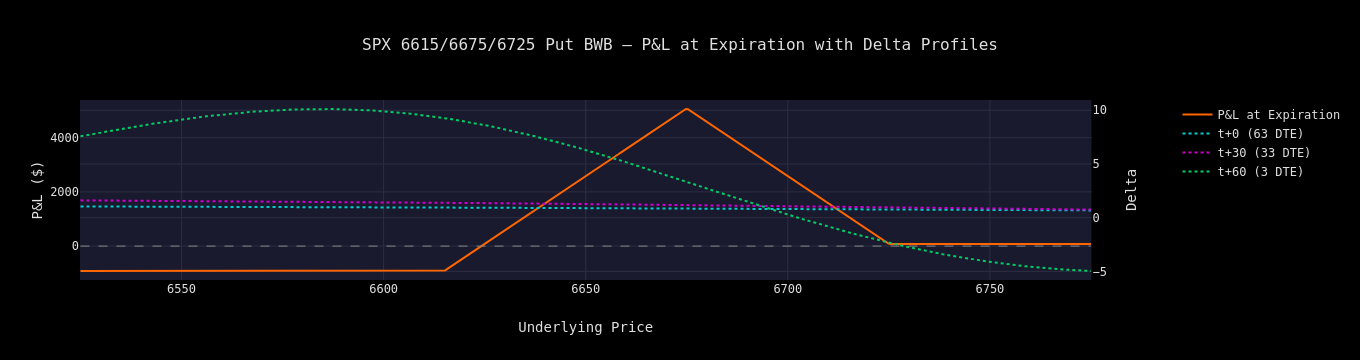

Max profit:  $  5,059.96
Max loss:    $   -920.00
Breakevens:  $6,624.20


In [6]:
import numpy as np

from options_analyzer.engine.greeks_calculator import GreeksCalculator
from options_analyzer.engine.payoff import PayoffCalculator
from options_analyzer.engine.position_analyzer import PositionAnalyzer
from options_analyzer.visualization.decay_charts import plot_payoff_with_delta

# Price range: short_strike -150 to +100, 500 points
price_range = np.linspace(short_strike - 150, short_strike + 100, 500)

# Expiration payoff
payoff_calc = PayoffCalculator(
    risk_free_rate=r,
    dividend_yield=q,
)
payoff = payoff_calc.expiration_payoff(bwb, price_range)

# Delta profiles at multiple DTEs
greeks_calc = GreeksCalculator(risk_free_rate=r, dividend_yield=q)
analyzer = PositionAnalyzer(greeks_calc)

ivs = {leg.contract.symbol: FLAT_IV for leg in bwb.legs}

# Build DTE list: t+0 = full DTE, t+30, t+60 (guard against negative)
dte_list = [dte]
for offset in [30, 60]:
    remaining = dte - offset
    if remaining > 0:
        dte_list.append(remaining)
    else:
        print(f"Warning: t+{offset} skipped (would be {remaining} DTE)")

delta_by_dte = analyzer.delta_vs_price_at_dtes(bwb, price_range, ivs, dte_list)

# Relabel keys for clearer legend: "65 DTE" -> "t+0 (65 DTE)"
relabeled = {}
for i, orig_dte in enumerate(dte_list):
    old_key = f"{orig_dte:g} DTE"
    offset = dte - orig_dte
    new_key = f"t+{offset} ({orig_dte} DTE)"
    relabeled[new_key] = delta_by_dte[old_key]

fig = plot_payoff_with_delta(
    price_range,
    payoff,
    relabeled,
    title=f"{bwb.name} — P&L at Expiration with Delta Profiles",
)
fig.show()

# Summary stats
max_profit = payoff.max()
max_loss = payoff.min()
sign_changes = np.where(np.diff(np.sign(payoff)))[0]
breakevens = [float(price_range[i]) for i in sign_changes]

print(f"Max profit:  ${max_profit:>10,.2f}")
print(f"Max loss:    ${max_loss:>10,.2f}")
print(f"Breakevens:  {', '.join(f'${b:,.2f}' for b in breakevens)}")

## 6. P&L at Expiration with Theoretical P&L

Single Y-axis overlay showing:
- **Solid orange**: Expiration P&L (the hockey-stick payoff)
- **Dotted lines**: Theoretical P&L at t+0, t+30, t+60

The dotted curves converge toward the solid expiration payoff as DTE decreases,
revealing how the position's P&L shape evolves over time.

In [ ]:
from options_analyzer.visualization.payoff_charts import plot_payoff_with_theoretical_pnl

# Compute theoretical P&L at same DTE offsets
pnl_by_dte = {}
for orig_dte in dte_list:
    offset = dte - orig_dte
    label = f"t+{offset} ({orig_dte} DTE)"
    pnl_by_dte[label] = payoff_calc.theoretical_pnl(bwb, price_range, ivs, orig_dte)

fig = plot_payoff_with_theoretical_pnl(
    price_range,
    payoff,
    pnl_by_dte,
    title=f"{bwb.name} — P&L at Expiration with Theoretical P&L",
)
fig.show()

## 7. Cleanup

In [7]:
await providers.disconnect()
print("Session disconnected.")

Session disconnected.
